In [ ]:
import pandas as pd

import numpy as np

import os

import geopandas
from shapely.geometry import Point

import re

import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.animation as ani
import matplotlib.font_manager as font_manager
import seaborn as sns

from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from pyspark.sql import SparkSession

import ast

path = os.path.dirname(os.getcwd())

dr_path = path + r"/rest_dr"
dc_path = path + r"/rest_dc"

op_path = path + r"/rest_op"

print(dr_path)



c:\Users\sstei\OneDrive\steiner_research\restaurants_project/rest_dr


## Import census tract data

In [2]:
tn_tract = geopandas.read_file(dr_path + r"/tl_2024_47_tract/tl_2024_47_tract.shp")

tn_tract.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,GEOIDFQ,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,47,073,050501,47073050501,1400000US47073050501,505.01,Census Tract 505.01,G5020,S,83355996,0,+36.5659159,-082.7715246,"POLYGON ((-82.85011 36.54107, -82.84955 36.541..."
1,47,073,050601,47073050601,1400000US47073050601,506.01,Census Tract 506.01,G5020,S,23847669,177932,+36.5836443,-082.6318663,"POLYGON ((-82.68939 36.58793, -82.68936 36.588..."
2,47,073,050602,47073050602,1400000US47073050602,506.02,Census Tract 506.02,G5020,S,23386547,668716,+36.5467218,-082.6458382,"POLYGON ((-82.69446 36.54856, -82.69445 36.548..."
3,47,073,050502,47073050502,1400000US47073050502,505.02,Census Tract 505.02,G5020,S,32873931,311980,+36.5332207,-082.7586081,"POLYGON ((-82.82242 36.52006, -82.82171 36.520..."
4,47,073,050503,47073050503,1400000US47073050503,505.03,Census Tract 505.03,G5020,S,17050728,568444,+36.5225397,-082.6970280,"POLYGON ((-82.73162 36.52804, -82.73108 36.528..."


In [3]:
davidson_tracts = geopandas.GeoDataFrame(tn_tract[tn_tract['COUNTYFP']=='037'][['GEOID', 'geometry']].reset_index(drop=True))

davidson_tracts = davidson_tracts.rename(columns={'GEOID':'tract_id'}).to_crs('epsg:4326')

davidson_tracts.head()

,tract_id,geometry
0,47037010103,"POLYGON ((-86.91752 36.33976, -86.91747 36.339..."
1,47037010202,"POLYGON ((-86.82483 36.33225, -86.82480 36.332..."
2,47037010104,"POLYGON ((-86.97440 36.24991, -86.97244 36.252..."
3,47037010106,"POLYGON ((-86.83089 36.26570, -86.83016 36.265..."
4,47037010602,"POLYGON ((-86.69530 36.25263, -86.69513 36.253..."


## Clean Yelp Business data

In [4]:
business = pd.read_json(dr_path + r"/Yelp JSON/yelp_dataset/yelp_academic_dataset_business.json", lines=True)

business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [5]:
business['city'].unique()

array(['Santa Barbara', 'Affton', 'Tucson', ..., 'Wales',
       'UPPER MORELAND', 'Apollo beach'], dtype=object)

In [6]:
nash_business = business[(business['categories'].astype(str).str.contains('Restaurants')) &
                         (business['city']=='Nashville') & (business['state']=='TN')].reset_index(drop=True)

nash_business_chars = pd.json_normalize(nash_business['attributes'])

nash_business = pd.concat([nash_business, nash_business_chars], axis=1) #, nash_business_diet

### Clean restaurant category variables
nash_business_cats = nash_business.set_index('business_id')['categories'].str.split(',', expand=True).reset_index() #.head()

nash_business_cats = nash_business_cats.melt(id_vars='business_id').drop(['variable'], axis=1)
nash_business_cats = nash_business_cats[nash_business_cats['value'].isnull()==0].reset_index(drop=True)

nash_business_cats['dummy'] = 1

nash_business_cats = nash_business_cats.pivot(index=['business_id'], columns=['value']).fillna(0).astype(int).reset_index()

nash_business_cats.columns = list(nash_business_cats.columns.droplevel(1))[:1] + list(nash_business_cats.columns.droplevel(0))[1:]

print(len(nash_business))
nash_business = nash_business.merge(nash_business_cats, on=['business_id'], how='left')
print(len(nash_business))

### Clean attribute columns
none_convert = {'none':'999', 'None':'999', None:'999', '':'999', np.nan:'999'}

fill_with_none = ['RestaurantsCounterService', 'RestaurantsGoodForGroups', 'BusinessAcceptsCreditCards', 'OutdoorSeating', 
                  'GoodForKids', 'Alcohol', 'DogsAllowed', 'RestaurantsTableService', 'ByAppointmentOnly', 'WiFi',
                  'RestaurantsReservations', 'HasTV', 'RestaurantsDelivery', 'CoatCheck', 'RestaurantsAttire',
                  'Caters', 'RestaurantsTakeOut', 'DriveThru', 'HappyHour', 'WheelchairAccessible', 'NoiseLevel', 
                  'BikeParking', 'BusinessAcceptsBitcoin', 'Smoking', 'GoodForDancing', 'BYOBCorkage', 'BYOB', 
                  'Open24Hours', 'Corkage', 'AgesAllowed']
for col in fill_with_none:
    nash_business[col] = nash_business[col].replace(none_convert).apply(lambda x: ast.literal_eval(x))
    
    nash_business[col] = nash_business[col].replace({False:0, True:1, 'none':'999'}).astype(str)
    
    nash_business[col] = nash_business[col].astype('category').cat.codes

nash_business['RestaurantsPriceRange2'] = nash_business['RestaurantsPriceRange2'].replace(none_convert).astype(int).astype('category').cat.codes

nash_business['ln_reviewct'] = np.log(nash_business['review_count'])

nash_business = nash_business.drop(['DietaryRestrictions', 'BusinessParking', 'Ambience', 'GoodForMeal', 'BestNights', 'Music'], axis=1)

### Merge location data
nash_business['geometry'] = geopandas.points_from_xy(nash_business['longitude'], nash_business['latitude'])

nash_business = geopandas.GeoDataFrame(nash_business, crs='epsg:4326') #.drop(['HairSpecializesIn', 'AcceptsInsurance'], axis=1)

print(len(nash_business))
nash_business = davidson_tracts.sjoin(nash_business).drop(['geometry', 'index_right'], axis=1).reset_index(drop=True)
print(len(nash_business))

nash_business['geometry'] = geopandas.points_from_xy(nash_business['longitude'], nash_business['latitude'])

nash_business['tract_id'] = pd.Categorical(nash_business['tract_id'])

nash_business = geopandas.GeoDataFrame(nash_business, crs='epsg:4326')

# nash_business['stars'] = round(nash_business['stars'], 0)

nash_business.head()

2502
2502
2502
2498


,tract_id,business_id,name,address,city,state,postal_code,latitude,longitude,stars,...,Vegan,Vegetarian,Venues & Event Spaces,Vietnamese,Waffles,Whiskey Bars,Wine Bars,Wraps,ln_reviewct,geometry
0,47037010106,piPnsKY7GE-B5KVQs8ubsA,Café Fontanella,4125 Whites Creek Pike,Nashville,TN,37189,36.257214,-86.829532,3.0,...,0,0,0,0,0,0,0,0,4.820282,POINT (-86.82953 36.25721)
1,47037019200,d4ZPdoYxDnT6f70AZPGrcw,Sky Blue Cafe,700 Fatherland St,Nashville,TN,37206,36.171418,-86.758903,4.0,...,0,0,0,0,0,0,0,0,6.728629,POINT (-86.75890 36.17142)
2,47037019200,zJmp_J8SUNosLxk6borpFg,The Wild Cow,"1100 Fatherland St, Ste 104",Nashville,TN,37206,36.173823,-86.750055,4.5,...,0,0,0,0,0,0,0,0,6.900731,POINT (-86.75006 36.17382)
3,47037019200,vSvbdFKfr6u5-zykn49CWA,Maru Sushi & Grill - East Nashville,"1100 Fatherland St, Ste 101",Nashville,TN,37206,36.173913,-86.750084,4.5,...,0,0,0,0,0,0,0,0,5.099866,POINT (-86.75008 36.17391)
4,47037019200,vWmh3kJuehx3tDp6rrtqgA,Local Taco,"1100 Fatherland St, Ste 104",Nashville,TN,37206,36.173936,-86.750126,3.5,...,0,0,0,0,0,0,0,0,5.105945,POINT (-86.75013 36.17394)


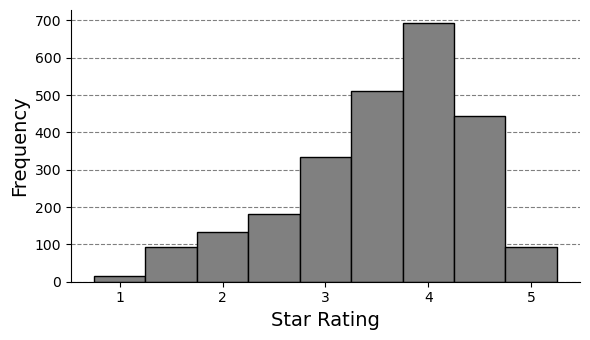

In [7]:
fig, ax = plt.subplots(figsize=(6, 3.5))

nash_business_count = nash_business[['stars', 'business_id']].groupby(['stars'], as_index=False).nunique()

ax.bar(nash_business_count['stars'], nash_business_count['business_id'], color='gray', edgecolor='black', width=0.5)

ax.set_ylabel('Frequency', fontsize=14)
ax.set_xlabel('Star Rating', fontsize=14)

ax.set_axisbelow(True)
ax.grid(axis='y', linestyle='--', color='black', alpha=0.5)

sns.despine()

plt.tight_layout()

plt.show()

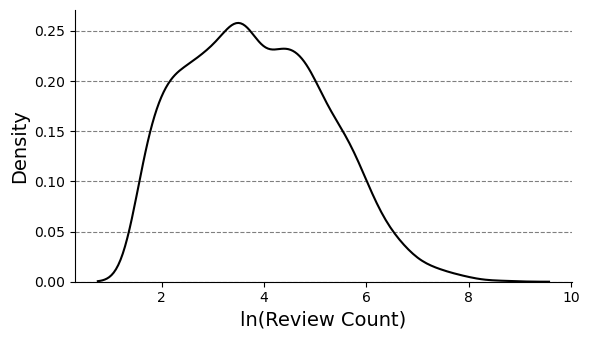

In [8]:
fig, ax = plt.subplots(figsize=(6, 3.5))

sns.kdeplot(x='ln_reviewct', data=nash_business, color='black')

ax.set_xlabel('ln(Review Count)', fontsize=14)
ax.set_ylabel('Density', fontsize=14)

ax.set_axisbelow(True)
ax.grid(axis='y', linestyle='--', color='black', alpha=0.5)

sns.despine()

plt.tight_layout()

plt.show()

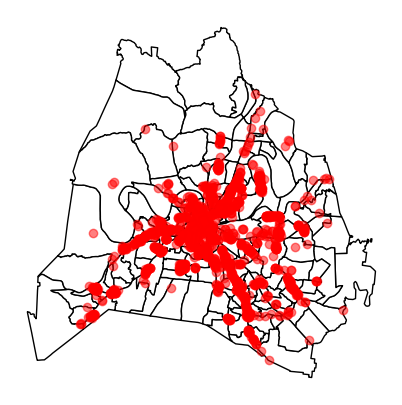

In [9]:
fig, ax = plt.subplots(figsize=(5,5))

davidson_tracts.plot(ax=ax, color='white', edgecolor='black')
nash_business.plot(ax=ax, color='red', alpha=0.5)

ax.axis('off')

plt.show()

## Import and clean Yelp Review data

In [10]:
spark = SparkSession \
    .builder \
    .appName("Yelp Review data") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [11]:
bus_idlist = nash_business['business_id'].to_list()

In [12]:
reviews_sp = spark.read.json(dr_path + r"/Yelp JSON/yelp_dataset/yelp_academic_dataset_review.json")

reviews_sp.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [13]:
nash_reviews_sp = reviews_sp.filter(reviews_sp.business_id.isin(bus_idlist))

nash_reviews_sp.show()

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|ltBBYdNzkeKdCNPDA...|   0|2015-02-02 04:29:13|    0|elqRpX9T3YwL07uLN...|  2.0|I at least have t...|     0|-sryo4gDYxbZ1T5Bz...|
|Zx7n8mdt8OzLRXVzo...|   0|2018-04-27 23:03:21|    0|E9AB7V4z8xrt2uPF7...|  5.0|Amazing biscuits ...|     0|iYY5Ii1LGpZCpXFkH...|
|eaJCpC6IhYphj7bwC...|   0|2015-08-30 13:41:47|    0|qGQvUHmC02PAZW3H1...|  5.0|Stopped by after ...|     0|RRTQpg8hutdimzAYu...|
|oQ5CPRt0R3AzFvcjN...|   0|2016-01-17 13:26:19|    0|67cGcRrS0jTvB8p7r...|  3.0|Honestly the food...|     1|8YSxVaD203mE_9FR4...|
|9OtFX3YzG5keaUMOW...|   0|2014-05-26 01:56:19|    0|DOeEDBfsrNph0ktNk...|  5.0|Man. This 

In [14]:
nash_reviews = nash_reviews_sp.toPandas()

nash_reviews.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,ltBBYdNzkeKdCNPDAsxwAA,0,2015-02-02 04:29:13,0,elqRpX9T3YwL07uLNtN3Bg,2.0,I at least have to give this restaurant two st...,0,-sryo4gDYxbZ1T5Bz4l5Bw
1,Zx7n8mdt8OzLRXVzolXNhQ,0,2018-04-27 23:03:21,0,E9AB7V4z8xrt2uPF7T55FQ,5.0,Amazing biscuits and (fill in the blank). Grea...,0,iYY5Ii1LGpZCpXFkHlMefw
2,eaJCpC6IhYphj7bwCDHTwQ,0,2015-08-30 13:41:47,0,qGQvUHmC02PAZW3H1WTIfw,5.0,Stopped by after a Sunday morning walk in the ...,0,RRTQpg8hutdimzAYuP_Hbw
3,oQ5CPRt0R3AzFvcjNOqB1w,0,2016-01-17 13:26:19,0,67cGcRrS0jTvB8p7rpaPew,3.0,Honestly the food doesn't knock my socks off b...,1,8YSxVaD203mE_9FR4nCEVA
4,9OtFX3YzG5keaUMOWU1imA,0,2014-05-26 01:56:19,0,DOeEDBfsrNph0ktNkYYFnQ,5.0,Man. This place is nice. The bartender was awe...,4,qVYilGRmY6uemAy_tDpfuA


## Review analysis through K-Means followed by text summary

In [15]:
nash_reviews2 = nash_reviews.copy()

# Step 1: Vectorize text
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(nash_reviews2['text'])

# Step 2: Cluster using KMeans
num_clusters = 10
model = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
model.fit(X)

nash_reviews2['cluster'] = model.labels_

nash_reviews2.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,cluster
0,ltBBYdNzkeKdCNPDAsxwAA,0,2015-02-02 04:29:13,0,elqRpX9T3YwL07uLNtN3Bg,2.0,I at least have to give this restaurant two st...,0,-sryo4gDYxbZ1T5Bz4l5Bw,4
1,Zx7n8mdt8OzLRXVzolXNhQ,0,2018-04-27 23:03:21,0,E9AB7V4z8xrt2uPF7T55FQ,5.0,Amazing biscuits and (fill in the blank). Grea...,0,iYY5Ii1LGpZCpXFkHlMefw,6
2,eaJCpC6IhYphj7bwCDHTwQ,0,2015-08-30 13:41:47,0,qGQvUHmC02PAZW3H1WTIfw,5.0,Stopped by after a Sunday morning walk in the ...,0,RRTQpg8hutdimzAYuP_Hbw,5
3,oQ5CPRt0R3AzFvcjNOqB1w,0,2016-01-17 13:26:19,0,67cGcRrS0jTvB8p7rpaPew,3.0,Honestly the food doesn't knock my socks off b...,1,8YSxVaD203mE_9FR4nCEVA,4
4,9OtFX3YzG5keaUMOWU1imA,0,2014-05-26 01:56:19,0,DOeEDBfsrNph0ktNkYYFnQ,5.0,Man. This place is nice. The bartender was awe...,4,qVYilGRmY6uemAy_tDpfuA,3


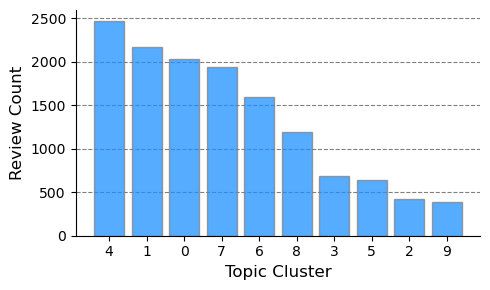

In [16]:
cluster_check = nash_reviews2[['cluster', 'business_id']].groupby(['cluster'], as_index=False).nunique().sort_values('business_id', ascending=False)

cluster_check['cluster'] = cluster_check['cluster'].astype('str')

fig, ax = plt.subplots(figsize=(5, 3))

ax.bar(cluster_check['cluster'], cluster_check['business_id'], edgecolor='gray', color='dodgerblue', alpha=0.75)

ax.set_ylabel('Review Count', fontsize=12)

ax.set_xlabel('Topic Cluster', fontsize=12)

ax.set_axisbelow(True)
ax.grid(axis='y', linestyle='--', alpha=0.5, color='black')

sns.despine()

plt.tight_layout()

plt.show()

In [17]:
alltext_clusters = nash_reviews2[['cluster', 'text']].groupby(['cluster'], as_index=False).agg({'text':lambda x: ' '.join(x)})

for i in alltext_clusters['cluster'].unique():
    with open(op_path + f"/cluster{i}_alltext.txt", 'w') as file:
        file.write(alltext_clusters.loc[alltext_clusters['cluster']==i, 'text'].unique()[0])
        file.write('\n')

alltext_clusters

,cluster,text
0,0,Been to this location twice and will never go ...
1,1,"This is a pretty good pancake place, but it's ..."
2,2,The Tuck Special. So good I would drive all th...
3,3,Man. This place is nice. The bartender was awe...
4,4,I at least have to give this restaurant two st...
5,5,Stopped by after a Sunday morning walk in the ...
6,6,Amazing biscuits and (fill in the blank). Grea...
7,7,Like wholefoods but much smaller. They have al...
8,8,"First time visit the other day, amazing!!!! Be..."
9,9,"Horrible experience, pizza was soggy and cold ..."


In [18]:
# import nltk
# nltk.download('punkt')

# from sumy.parsers.plaintext import PlaintextParser
# from sumy.nlp.tokenizers import Tokenizer
# from sumy.summarizers.lsa import LsaSummarizer

In [19]:
# text = alltext_clusters.loc[alltext_clusters['cluster']==i, 'text'].unique()[0]
# parser = PlaintextParser.from_string(text, Tokenizer("english"))
# summarizer = LsaSummarizer()
# summary = summarizer(parser.document, sentences_count=5)

# for sentence in summary:
#     print(sentence)

## Export to CSV for analysis

In [20]:
nash_reviews_group = nash_reviews2[['business_id', 'cool', 'funny', 'useful', 'cluster', 'review_id']].reset_index(drop=True)

nash_reviews_group_cluster = nash_reviews_group[['business_id', 'cluster', 'review_id']].groupby(['business_id', 'cluster'], as_index=False).nunique()

nash_reviews_group_cluster = nash_reviews_group_cluster.pivot(index=['business_id'], columns=['cluster']).fillna(0).astype(int).reset_index()

newcol_list = list(nash_reviews_group_cluster.columns.droplevel(1))[:1] + list(nash_reviews_group_cluster.columns.droplevel(0))[1:]
nash_reviews_group_cluster.columns = [f"kmeans_{col}" if len(str(col))==1 else col for col in newcol_list]

group_dict = {'cool':'sum', 'funny':'sum', 'useful':'sum', 'review_id':'nunique'}
nash_reviews_group = nash_reviews_group.drop('cluster', axis=1).groupby(['business_id'], as_index=False).agg(group_dict).rename(columns={'review_id':'review_count'})

print(len(nash_reviews_group))
nash_reviews_group = nash_reviews_group.merge(nash_reviews_group_cluster, on=['business_id'], how='left')
print(len(nash_reviews_group))

### Calculate proportion of total reviews in each cluster
for col in nash_reviews_group.columns:
    if 'kmeans' in col:
        nash_reviews_group[f"{col}_prop"] = nash_reviews_group[col] / nash_reviews_group['review_count']

nash_reviews_group.head()

2498
2498


,business_id,cool,funny,useful,review_count,kmeans_0,kmeans_1,kmeans_2,kmeans_3,kmeans_4,...,kmeans_0_prop,kmeans_1_prop,kmeans_2_prop,kmeans_3_prop,kmeans_4_prop,kmeans_5_prop,kmeans_6_prop,kmeans_7_prop,kmeans_8_prop,kmeans_9_prop
0,-1EGqUQFBmGEp76CE-Zk4Q,5,5,13,37,2,9,0,0,23,...,0.054054,0.243243,0.0,0.000000,0.621622,0.027027,0.000000,0.054054,0.000000,0.0
1,-3Xl8nSBSjaPpftsSNyrgg,1,0,0,7,1,0,0,0,5,...,0.142857,0.000000,0.0,0.000000,0.714286,0.000000,0.142857,0.000000,0.000000,0.0
2,-6nqH2tdNHQdqb8LvILlBw,34,15,83,127,19,29,0,0,66,...,0.149606,0.228346,0.0,0.000000,0.519685,0.000000,0.023622,0.062992,0.015748,0.0
3,-7CqBmK0zxwyjEqa3LBVSw,12,13,22,35,11,0,0,4,17,...,0.314286,0.000000,0.0,0.114286,0.485714,0.028571,0.000000,0.057143,0.000000,0.0
4,-951Q5if-JmCQbO40meVPw,0,1,1,10,1,1,0,0,3,...,0.100000,0.100000,0.0,0.000000,0.300000,0.000000,0.000000,0.000000,0.000000,0.5


In [21]:
print(len(nash_business))
nash_database = nash_business.merge(nash_reviews_group.drop(['review_count'], axis=1), on=['business_id'], how='inner')
print(len(nash_database))

### Export for analysis
nash_database.to_csv(dc_path + r"/nashrestaurants_clean.csv", index=False)

nash_database.head()

2498
2498


,tract_id,business_id,name,address,city,state,postal_code,latitude,longitude,stars,...,kmeans_0_prop,kmeans_1_prop,kmeans_2_prop,kmeans_3_prop,kmeans_4_prop,kmeans_5_prop,kmeans_6_prop,kmeans_7_prop,kmeans_8_prop,kmeans_9_prop
0,47037010106,piPnsKY7GE-B5KVQs8ubsA,Café Fontanella,4125 Whites Creek Pike,Nashville,TN,37189,36.257214,-86.829532,3.0,...,0.251969,0.212598,0.000000,0.000000,0.322835,0.000000,0.023622,0.078740,0.007874,0.102362
1,47037019200,d4ZPdoYxDnT6f70AZPGrcw,Sky Blue Cafe,700 Fatherland St,Nashville,TN,37206,36.171418,-86.758903,4.0,...,0.175439,0.133333,0.000000,0.011696,0.308772,0.212865,0.065497,0.084211,0.007018,0.001170
2,47037019200,zJmp_J8SUNosLxk6borpFg,The Wild Cow,"1100 Fatherland St, Ste 104",Nashville,TN,37206,36.173823,-86.750055,4.5,...,0.050098,0.196464,0.000000,0.038310,0.505894,0.001965,0.103143,0.102161,0.001965,0.000000
3,47037019200,vSvbdFKfr6u5-zykn49CWA,Maru Sushi & Grill - East Nashville,"1100 Fatherland St, Ste 101",Nashville,TN,37206,36.173913,-86.750084,4.5,...,0.067416,0.230337,0.000000,0.000000,0.471910,0.000000,0.134831,0.089888,0.005618,0.000000
4,47037019200,vWmh3kJuehx3tDp6rrtqgA,Local Taco,"1100 Fatherland St, Ste 104",Nashville,TN,37206,36.173936,-86.750126,3.5,...,0.132530,0.349398,0.012048,0.000000,0.349398,0.000000,0.030120,0.084337,0.042169,0.000000
